In [10]:
# =============================================================================
# PART 1: SETUP & DEPENDENCIES
# =============================================================================
# Install all required packages for Neo4j, visualization, and data handling
!pip install neo4j pandas pyvis tqdm matplotlib plotly

In [11]:
# Import necessary libraries
import pandas as pd
import random
from datetime import datetime, timedelta
import collections
from tqdm.auto import tqdm  # For progress bars
from neo4j import GraphDatabase
from pyvis.network import Network
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json

print("All libraries installed and imported successfully.")

All libraries installed and imported successfully.


In [12]:
# =============================================================================
# PART 2: NEO4J DATABASE CONNECTION
# =============================================================================
NEO4J_URI = "neo4j+s://63c356b1.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "T09WvjN-00q_0sjK5B9qj_tjPWUky3Afwu946zvVZl8"

# --- Helper Function to run queries ---
def run_query(driver, query, params={}):
    """
    A helper function to run a Cypher query with parameters
    and return the result as a pandas DataFrame.
    """
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.data() for r in result])

# --- Test Connection ---
try:
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    driver.verify_connectivity()
    print("Successfully connected to Neo4j AuraDB!")

    # Clean the database for a fresh start
    print("Cleaning database (MATCH (n) DETACH DELETE n)...")
    run_query(driver, "MATCH (n) DETACH DELETE n")
    print("Database is clean.")

except Exception as e:
    print(f"Error connecting to Neo4j. Please check your credentials: {e}")
    driver = None # Set driver to None if connection fails

Successfully connected to Neo4j AuraDB!
Cleaning database (MATCH (n) DETACH DELETE n)...
Database is clean.


In [13]:
# =============================================================================
# PART 3: DATA ACQUISITION & PREPROCESSING
# =============================================================================

sessions_data = []
categories = ['Electronics', 'Apparel', 'Books', 'Home']
user_ids = ['U101', 'U102', 'U103']
start_time = datetime(2025, 10, 10, 9, 0, 0)

# Generate 10 sessions for a richer graph
for i in range(10):
    session_id = f'S_{i+1}'
    user_id = random.choice(user_ids)
    num_events = random.randint(3, 6)
    current_time = start_time + timedelta(hours=random.randint(1, 24), minutes=random.randint(1, 59))
    session_events = []

    for j in range(num_events):
        event_id = f'E_{session_id}_{j+1}'
        item_id = f'I_{random.randint(100, 120)}' # Fewer items for more co-occurrence
        category = random.choice(categories)
        action = random.choice(['click', 'click', 'click', 'purchase']) # Clicks are more frequent
        sequence_order = j + 1

        sessions_data.append({
            'sessionID': session_id,
            'userID': user_id,
            'eventID': event_id,
            'itemID': item_id,
            'category': category,
            'action': action,
            # Format timestamp as ISO 8601 for Neo4j datetime()
            'timestamp': current_time.isoformat(),
            'sequenceOrder': sequence_order
        })
        current_time += timedelta(minutes=random.randint(1, 10))

df = pd.DataFrame(sessions_data)

# Convert DataFrame to a list of dictionaries for batch loading
data_batch = df.to_dict('records')

print("--- Synthetic Session Data Sample ---")
print(df.head(10).to_string())

--- Synthetic Session Data Sample ---
  sessionID userID  eventID itemID     category    action            timestamp  sequenceOrder
0       S_1   U102  E_S_1_1  I_117  Electronics     click  2025-10-10T21:59:00              1
1       S_1   U102  E_S_1_2  I_116  Electronics     click  2025-10-10T22:07:00              2
2       S_1   U102  E_S_1_3  I_116        Books     click  2025-10-10T22:11:00              3
3       S_1   U102  E_S_1_4  I_100  Electronics     click  2025-10-10T22:15:00              4
4       S_1   U102  E_S_1_5  I_111      Apparel     click  2025-10-10T22:18:00              5
5       S_2   U103  E_S_2_1  I_116         Home     click  2025-10-10T21:52:00              1
6       S_2   U103  E_S_2_2  I_101  Electronics     click  2025-10-10T21:57:00              2
7       S_2   U103  E_S_2_3  I_102      Apparel     click  2025-10-10T22:01:00              3
8       S_2   U103  E_S_2_4  I_104      Apparel  purchase  2025-10-10T22:08:00              4
9       S_2   U103  E_

In [14]:
# =============================================================================
# PART 4: GRAPH CONSTRUCTION (NEO4J)
# =============================================================================
# This part replaces the NetworkX logic with robust Cypher queries.

if driver:
    # --- 4.1: Create Constraints for Performance ---
    # Constraints ensure nodes are unique and speed up MERGE operations.
    print("\n--- Creating Graph Constraints ---")
    run_query(driver, "CREATE CONSTRAINT IF NOT EXISTS FOR (s:Session) REQUIRE s.id IS UNIQUE")
    run_query(driver, "CREATE CONSTRAINT IF NOT EXISTS FOR (u:User) REQUIRE u.id IS UNIQUE")
    run_query(driver, "CREATE CONSTRAINT IF NOT EXISTS FOR (e:Event) REQUIRE e.id IS UNIQUE")
    run_query(driver, "CREATE CONSTRAINT IF NOT EXISTS FOR (i:Item) REQUIRE i.id IS UNIQUE")
    run_query(driver, "CREATE CONSTRAINT IF NOT EXISTS FOR (c:Category) REQUIRE c.name IS UNIQUE")
    print("Constraints created.")

    # --- 4.2: Batch Load Nodes & Structural Edges ---
    # We use UNWIND to efficiently load the data from our Python list.
    print("\n--- Loading Structural Data (Nodes & Edges) ---")

    load_query = """
    UNWIND $batch AS row

    // MERGE (find or create) the main entities
    MERGE (s:Session {id: row.sessionID})
    MERGE (u:User {id: row.userID})
    MERGE (i:Item {id: row.itemID})
    MERGE (c:Category {name: row.category})

    // CREATE the unique Event node
    CREATE (e:Event {
        id: row.eventID,
        action: row.action,
        timestamp: datetime(row.timestamp),
        sequenceOrder: row.sequenceOrder
    })

    // Create the relationships
    MERGE (e)-[:OCCURRED_IN]->(s)
    MERGE (e)-[:IS_ITEM]->(i)
    MERGE (i)-[:BELONGS_TO]->(c)
    MERGE (s)-[:PERFORMED_BY]->(u)
    """

    # Run the batch load
    run_query(driver, load_query, params={'batch': data_batch})
    print(f"Successfully loaded {len(data_batch)} events into Neo4j.")

    # --- 4.3: Create Sequential (PRECEDES) Edges ---
    # This query connects events within a session in order.
    print("\n--- Creating :PRECEDES Sequential Edges ---")
    precedes_query = """
    MATCH (s:Session)<-[:OCCURRED_IN]-(e1:Event)
    MATCH (s)<-[:OCCURRED_IN]-(e2:Event)

    // Find events where e2 directly follows e1
    WHERE e1.sequenceOrder = e2.sequenceOrder - 1

    // Create the sequential link
    MERGE (e1)-[r:PRECEDES]->(e2)
    SET r.weight = 1 // Set a baseline weight/frequency
    RETURN count(r) AS precedes_links_created
    """
    result_df = run_query(driver, precedes_query)
    print(f"Created {result_df['precedes_links_created'].sum()} :PRECEDES relationships.")

    # --- 4.4: Create Co-occurrence (CO_OCCURS_WITH) Edges ---
    # This query creates semantic links between *Categories*
    # that appear in the same session.
    print("\n--- Creating :CO_OCCURS_WITH Edges (Categories) ---")
    co_occur_query = """
    MATCH (s:Session)<-[:OCCURRED_IN]-(e1:Event)
    MATCH (e1)-[:IS_ITEM]->(:Item)-[:BELONGS_TO]->(c1:Category)

    MATCH (s)<-[:OCCURRED_IN]-(e2:Event)
    MATCH (e2)-[:IS_ITEM]->(:Item)-[:BELONGS_TO]->(c2:Category)

    // Ensure we don't match a category with itself
    // and only create one edge per pair (c1 -> c2, not c2 -> c1)
    WHERE id(c1) < id(c2)

    // Merge the co-occurrence link and increment its frequency
    MERGE (c1)-[r:CO_OCCURS_WITH]-(c2)
    ON CREATE SET r.frequency = 1
    ON MATCH SET r.frequency = r.frequency + 1
    RETURN count(r) AS co_occur_links
    """
    run_query(driver, co_occur_query)
    print("Co-occurrence edges between categories updated.")


--- Creating Graph Constraints ---
Constraints created.

--- Loading Structural Data (Nodes & Edges) ---
Successfully loaded 54 events into Neo4j.

--- Creating :PRECEDES Sequential Edges ---
Created 44 :PRECEDES relationships.

--- Creating :CO_OCCURS_WITH Edges (Categories) ---


Co-occurrence edges between categories updated.


In [15]:
# =============================================================================
# PART 5: GRAPH-BASED REASONING: SEQUENCE RETRIEVAL
# =============================================================================
# This replaces the NetworkX traversal  with a Cypher query.

def get_session_sequence(driver, session_id):
    """
    Retrieves the ordered sequence of events for a given session ID
    by following the :PRECEDES path.
    """
    print(f"\n--- Reconstructing Session Sequence for {session_id} ---")

    # We find the *start* of the session (sequenceOrder = 1)
    # and then follow the path of :PRECEDES relationships.
    query = """
    MATCH (s:Session {id: $sessionID})

    // Find all events in this session
    MATCH (e:Event)-[:OCCURRED_IN]->(s)

    // Also find the item associated with the event
    MATCH (e)-[:IS_ITEM]->(i:Item)

    WITH e, i
    ORDER BY e.sequenceOrder

    RETURN
        e.sequenceOrder AS Order,
        e.id AS EventID,
        e.action AS Action,
        i.id AS ItemID
    """

    sequence_df = run_query(driver, query, params={'sessionID': session_id})

    if sequence_df.empty:
        print(f"No events found for session {session_id}.")
    else:
        print(sequence_df.to_string(index=False))

# --- Test the function ---
if driver:
    get_session_sequence(driver, 'S_1')
    get_session_sequence(driver, 'S_2')



--- Reconstructing Session Sequence for S_1 ---
 Order EventID Action ItemID
     1 E_S_1_1  click  I_117
     2 E_S_1_2  click  I_116
     3 E_S_1_3  click  I_116
     4 E_S_1_4  click  I_100
     5 E_S_1_5  click  I_111

--- Reconstructing Session Sequence for S_2 ---
 Order EventID   Action ItemID
     1 E_S_2_1    click  I_116
     2 E_S_2_2    click  I_101
     3 E_S_2_3    click  I_102
     4 E_S_2_4 purchase  I_104
     5 E_S_2_5    click  I_100


In [16]:
# =============================================================================
# PART 6: GRAPH-BASED REASONING: NEXT-STEP PREDICTION
# =============================================================================
# This replaces the NetworkX prediction  with Cypher.

def predict_next_item_by_frequency(driver, current_event_id):
    """
    Predicts the next item based on historical co-occurrence
    (i.e., which event most frequently followed the current event).
    """
    print(f"\n--- Predicting Next Item (by Frequency) after Event: {current_event_id} ---")

    # This query finds the current event and counts all
    # outgoing :PRECEDES relationships to find the most common next step.
    query = """
    MATCH (current:Event {id: $eventID})-[r:PRECEDES]->(next:Event)
    MATCH (next)-[:IS_ITEM]->(i:Item)

    RETURN
        i.id AS RecommendedItem,
        next.action AS Action,
        count(r) AS Frequency
    ORDER BY Frequency DESC
    LIMIT 5
    """

    prediction_df = run_query(driver, query, params={'eventID': current_event_id})

    if prediction_df.empty:
        print("No historical :PRECEDES transitions found from this event.")
    else:
        print(prediction_df.to_string(index=False))

    return prediction_df

# --- Test the function ---
# We'll grab an event from our S_1 sequence to test
if driver:
    # Let's test with 'E_S_1_3' (assuming it exists from the generator)
    test_event_id = "E_S_1_3"
    # Check if this event exists first
    check_df = run_query(driver, "MATCH (e:Event {id: $id}) RETURN e.id", {'id': test_event_id})
    if not check_df.empty:
        _ = predict_next_item_by_frequency(driver, test_event_id)
    else:
        print(f"Test event {test_event_id} not found. Trying 'E_S_2_2'.")
        test_event_id = "E_S_2_2"
        check_df_2 = run_query(driver, "MATCH (e:Event {id: $id}) RETURN e.id", {'id': test_event_id})
        if not check_df_2.empty:
            _ = predict_next_item_by_frequency(driver, test_event_id)
        else:
            print("Could not find a suitable test event.")



--- Predicting Next Item (by Frequency) after Event: E_S_1_3 ---
RecommendedItem Action  Frequency
          I_100  click          1


In [17]:
# =============================================================================
# PART 7 (Corrected): TEMPORAL-WEIGHTED PREDICTION
# =============================================================================
# This version is corrected to include the 'Action' in its output.

def predict_next_item_temporal(driver, current_event_id):
    """
    Predicts the next item, weighting recommendations by *recency*.
    Transitions that happened more recently get a higher score.
    (Version 2: Includes 'Action' in the output)
    """
    print(f"\n--- Predicting Next Item (Temporal Weight) after Event: {current_event_id} ---")

    query = """
    MATCH (current:Event {id: $eventID})-[r:PRECEDES]->(next:Event)
    MATCH (next)-[:IS_ITEM]->(i:Item)

    // Calculate time difference in seconds. Add 1 to avoid division by zero.
    WITH i, next,
         duration.between(current.timestamp, next.timestamp).seconds + 1.0 AS timeDiffSeconds

    // Calculate a recency score.
    WITH i, next.action AS Action, (1.0 / timeDiffSeconds) AS recencyScore

    // --- FIX APPLIED HERE ---
    // Group by Item AND Action to get the aggregate score for that specific next step
    RETURN
        i.id AS RecommendedItem,
        Action,
        sum(recencyScore) AS TotalRecencyScore
    ORDER BY TotalRecencyScore DESC
    LIMIT 5
    """

    prediction_df = run_query(driver, query, params={'eventID': current_event_id})

    if prediction_df.empty:
        print("No historical :PRECEDES transitions found from this event.")
    else:
        # Format the score for readability
        prediction_df['TotalRecencyScore'] = prediction_df['TotalRecencyScore'].round(4)
        print(prediction_df.to_string(index=False))

    return prediction_df

In [18]:
# =============================================================================
# PART 9 (Corrected): LLM HYBRID REASONING
# =============================================================================
# This version is corrected to check if the 'Action' column exists.

def get_llm_explanation(prediction_df, event_id):
    """
    Simulates an LLM providing a natural language summary
    of the recommendation results.
    (Version 2: Fixes KeyError by checking for 'Action' column)
    """
    print(f"\n--- [LLM Hybrid Reasoning] Analysis for Event: {event_id} ---")

    if prediction_df.empty:
        return "No recommendations could be generated. This event appears to be a 'dead end' in the historical data, with no known subsequent events."

    top_rec = prediction_df.iloc[0]

    explanation = f"**Analysis Complete:**\n"
    explanation += f"The recommendation model analyzed the graph paths starting from event **{event_id}**.\n\n"

    # --- FIX APPLIED HERE ---
    # Check if 'Action' column exists and is not null before trying to access it
    if 'Action' in top_rec.index and pd.notna(top_rec['Action']):
        explanation += f"1.  **Top Recommendation:** The most probable next item is **{top_rec['RecommendedItem']}** (as a(n) '{top_rec['Action']}' action). \n"
    else:
        explanation += f"1.  **Top Recommendation:** The most probable next item is **{top_rec['RecommendedItem']}**.\n"
    # --- END OF FIX ---

    if 'Frequency' in prediction_df.columns:
        explanation += f"2.  **Reasoning (Frequency Model):** This recommendation is based on strong historical co-occurrence. The path from **{event_id}** to an event involving **{top_rec['RecommendedItem']}** has occurred **{top_rec['Frequency']}** time(s), making it the most common next step observed in past sessions.\n"

    if 'TotalRecencyScore' in prediction_df.columns:
         explanation += f"2.  **Reasoning (Temporal Model):** This recommendation is based on a high-recency weighted score of **{top_rec['TotalRecencyScore']:.4f}**. This indicates that the path from **{event_id}** to **{top_rec['RecommendedItem']}** has not only occurred, but has occurred *recently* or *quickly* after the source event, signaling strong, current user intent.\n"

    if len(prediction_df) > 1:
        other_recs = ", ".join(prediction_df['RecommendedItem'][1:])
        explanation += f"3.  **Other Options:** Other potential items in this context include: {other_recs}."

    return explanation

In [19]:
# =============================================================================
# PART 9 (Re-run): TEST LLM HYBRID REASONING
# =============================================================================
# Now we re-run the test that failed, using the corrected functions.

print("\n--- Re-running PART 9 with corrected functions ---")
if driver:
    # 1. Get a prediction
    test_event_id = "E_S_1_2" # Use the same event as before
    check_df = run_query(driver, "MATCH (e:Event {id: $id}) RETURN e.id", {'id': test_event_id})

    if not check_df.empty:
        # Test 1: Frequency (this worked before, should still work)
        freq_preds = predict_next_item_by_frequency(driver, test_event_id)
        print(get_llm_explanation(freq_preds, test_event_id))

        # Test 2: Temporal (this is the one that failed)
        temp_preds = predict_next_item_temporal(driver, test_event_id)
        print(get_llm_explanation(temp_preds, test_event_id))
    else:
        print(f"Skipping LLM test, event {test_event_id} not found.")


--- Re-running PART 9 with corrected functions ---

--- Predicting Next Item (by Frequency) after Event: E_S_1_2 ---
RecommendedItem Action  Frequency
          I_116  click          1

--- [LLM Hybrid Reasoning] Analysis for Event: E_S_1_2 ---
**Analysis Complete:**
The recommendation model analyzed the graph paths starting from event **E_S_1_2**.

1.  **Top Recommendation:** The most probable next item is **I_116** (as a(n) 'click' action). 
2.  **Reasoning (Frequency Model):** This recommendation is based on strong historical co-occurrence. The path from **E_S_1_2** to an event involving **I_116** has occurred **1** time(s), making it the most common next step observed in past sessions.


--- Predicting Next Item (Temporal Weight) after Event: E_S_1_2 ---
RecommendedItem Action  TotalRecencyScore
          I_116  click             0.0041

--- [LLM Hybrid Reasoning] Analysis for Event: E_S_1_2 ---
**Analysis Complete:**
The recommendation model analyzed the graph paths starting from

In [20]:
# =============================================================================
# PART 10 : EVALUATION METRICS (MRR SIMULATION)
# =============================================================================
# This part did not run last time due to the error.

def calculate_mrr(test_set_predictions):
    """
    Calculates Mean Reciprocal Rank (MRR) from a list of prediction results.
    """
    reciprocal_ranks = []

    for session_result in test_set_predictions:
        true_item = session_result['true_next_item']
        ranked_list = session_result['ranked_list']

        try:
            rank = ranked_list.index(true_item) + 1
            reciprocal_rank = 1.0 / rank
            reciprocal_ranks.append(reciprocal_rank)
        except ValueError:
            reciprocal_ranks.append(0.0)

    if not reciprocal_ranks:
        return 0.0

    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks)
    return mrr

# --- Simulated Evaluation Process ---
print(f"\n--- Simulating Performance Evaluation (MRR) ---")

if driver:
    # 1. Mock Test Set (EventID, TrueNextItemID)
    test_set_df = run_query(driver, """
    MATCH (e1:Event)-[:PRECEDES]->(e2:Event)
    MATCH (e2)-[:IS_ITEM]->(i2:Item)
    RETURN e1.id AS current_event, i2.id AS true_next_item
    LIMIT 10
    """)
    mock_test_set = [(row['current_event'], row['true_next_item']) for _, row in test_set_df.iterrows()]

    prediction_results = []

    if not mock_test_set:
        print("Could not generate a test set from the graph. MRR simulation skipped.")
    else:
        # 2. Run predictions for each test case
        for current_event, true_next_item in tqdm(mock_test_set, desc="Running MRR Test Set"):
            # Get the ranked list from our Neo4j model
            pred_df = predict_next_item_by_frequency(driver, current_event)
            ranked_list = pred_df['RecommendedItem'].tolist()

            prediction_results.append({
                'true_next_item': true_next_item,
                'ranked_list': ranked_list
            })

        # 3. Calculate MRR
        mrr_score = calculate_mrr(prediction_results)

        print(f"\n--- Simulated Performance Results ---")
        print(f"Total Test Cases: {len(prediction_results)}")
        print(f"Mean Reciprocal Rank (MRR): {mrr_score:.4f}")
        print("Evaluation successfully simulated using live Neo4j queries.")




--- Simulating Performance Evaluation (MRR) ---


Running MRR Test Set:   0%|          | 0/10 [00:00<?, ?it/s]


--- Predicting Next Item (by Frequency) after Event: E_S_8_4 ---
RecommendedItem Action  Frequency
          I_117  click          1

--- Predicting Next Item (by Frequency) after Event: E_S_10_1 ---
RecommendedItem   Action  Frequency
          I_117 purchase          1

--- Predicting Next Item (by Frequency) after Event: E_S_1_1 ---
RecommendedItem Action  Frequency
          I_116  click          1

--- Predicting Next Item (by Frequency) after Event: E_S_1_2 ---
RecommendedItem Action  Frequency
          I_116  click          1

--- Predicting Next Item (by Frequency) after Event: E_S_7_2 ---
RecommendedItem   Action  Frequency
          I_116 purchase          1

--- Predicting Next Item (by Frequency) after Event: E_S_7_3 ---
RecommendedItem   Action  Frequency
          I_116 purchase          1

--- Predicting Next Item (by Frequency) after Event: E_S_1_3 ---
RecommendedItem Action  Frequency
          I_100  click          1

--- Predicting Next Item (by Frequency) after Ev


--- Visualizing Graph using NetworkX (Static Image) ---

Static visualization saved as 'static_session_graph.png'.

Neo4j connection closed.


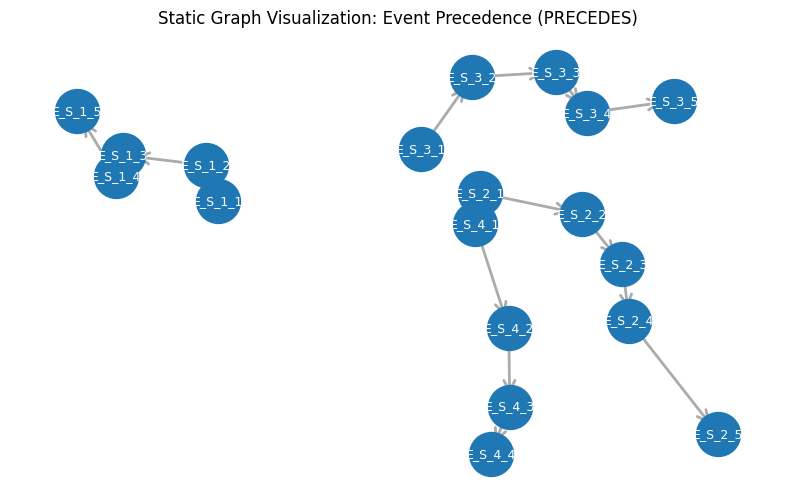

In [21]:
# =============================================================================
# PART 12: STATIC GRAPH VISUALIZATION (NetworkX/Matplotlib) - FINAL FIXED VERSION
# This version uses manual graph construction for compatibility with older NetworkX versions.
# =============================================================================

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

if 'driver' in locals() and driver:
    print("\n--- Visualizing Graph using NetworkX (Static Image) ---")

    simple_viz_query = """
    MATCH (e1:Event)-[p:PRECEDES]->(e2:Event)
    RETURN e1.id AS source, e2.id AS target, p.weight AS weight
    LIMIT 15
    """

    viz_df = pd.DataFrame()
    try:
        with driver.session() as session:
            result = session.run(simple_viz_query)
            viz_df = pd.DataFrame([r.values() for r in result], columns=result.keys())

            # --- Draw the Graph ---
            if not viz_df.empty:
                # the 'create_directed' keyword error.
                G = nx.DiGraph()

                # Populate the graph with edges and weights from the DataFrame
                for _, row in viz_df.iterrows():
                    G.add_edge(row['source'], row['target'], weight=row['weight'])

                plt.figure(figsize=(10, 6))
                pos = nx.spring_layout(G, k=0.15, iterations=20)  # positions for all nodes

                # Nodes
                nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="#1f77b4")

                # Edges
                weights = [d.get('weight', 1) * 2 for (u, v, d) in G.edges(data=True)]
                nx.draw_networkx_edges(G, pos, width=weights, edge_color="#888888", arrowstyle='->', arrowsize=20, alpha=0.7)

                # Labels
                nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif", font_color='white')

                plt.title("Static Graph Visualization: Event Precedence (PRECEDES)")
                plt.axis('off')
                plt.savefig("static_session_graph.png")
                print("\nStatic visualization saved as 'static_session_graph.png'.")

            else:
                print("\nCould not retrieve graph data or DataFrame is empty for static visualization.")

    except Exception as e:
        print(f"An error occurred during visualization: {e}")

else:
    print("\nNeo4j driver object is not available. Cannot execute visualization.")

# =============================================================================
# PART 13: FINAL CLEANUP
# =============================================================================
# The cleanup cell remains correct as it was designed to close the connection once all work is done.
if 'driver' in locals() and driver:
    driver.close()
    print("\nNeo4j connection closed.")
else:
    driver = None
    print("\nDriver not connected, no cleanup needed.")